In [1]:
#Sanjeet Devkota
#Predict News Category
# N * 128 * 64 * 32 * 16 * 1

# Evaluate Performance of Momentum, AdaGrad, RMSProb, and Adam optimizers
#In terms of accuracy and F1 Score.

In [2]:
# Importing Libraries

import numpy as np
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU
import tensorflow as tf
import keras.backend as K
from keras.optimizers import SGD, Adam, RMSprop, Adagrad

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from scipy.sparse import csr_matrix

# https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

# https://www.projectpro.io/recipes/reduce-dimentionality-on-sparse-matrix-in-python  # Use SVD for sparse matrix, how it works for single row of data for single news classification

# https://realpython.com/python-keras-text-classification/

# https://www.youtube.com/watch?v=qw7rkwsk0oc&ab_channel=DataScienceGarage # Learn about Padding

# https://www.kaggle.com/code/faressayah/20-news-groups-classification-prediction-cnns

# https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839  # Neural Network Multiclass Classification


In [3]:
categories = ['alt.atheism',
 'sci.crypt',
 'sci.electronics',
 'sci.med',

 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball'
]
num_class = len(categories)
news_data_train = fetch_20newsgroups(subset='train',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

news_data_test = fetch_20newsgroups(subset='test',
                               categories=categories,
                               remove=('headers', 'footers', 'quotes'))

In [4]:
dir(news_data_train)
# https://towardsdatascience.com/word-embedding-techniques-word2vec-and-tf-idf-explained-c5d02e34d08  #Good Read

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [5]:
vectorizer = TfidfVectorizer()
# fit() method is used to calculate necessary values to transform for example for standardScalar mean and standard deviation, fit only calculate the necessary calculation but do not apply that to the data point
# transform applies the calculation done by fit() to the data point
# fit_transform() do all at once.
X_train = vectorizer.fit_transform(news_data_train.data).toarray() # remove toarray() and use svd
print(f"Data Vectors Train Shape {X_train.shape}")

# Vectorize Test Data
MAX_LEN = X_train.shape[1]
data_vectors_test = vectorizer.fit_transform(news_data_test.data).toarray() # remove toarray() and use svd

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    data_vectors_test,
    value=0,
    padding="post",
    maxlen=MAX_LEN
)
print(f"Data Vectors Test Shape {X_test.shape}")

Data Vectors Train Shape (4634, 39530)
Data Vectors Test Shape (3085, 39530)


In [10]:
y_train = news_data_train.target
y_test = news_data_test.target

In [12]:
 #plt.hist(news_data.target)

In [8]:
# news_data.target

In [13]:
# Defining F1 Score Function

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
# Creating Model
#  N * 256 * 128 * 64 * 32 * 16* 0

def get_model_leakyrelu():
  model = Sequential()
  model.add(Input(X_train.shape[1]))

  model.add(Dense(256))
  model.add(LeakyReLU(0.05))
  model.add(Dropout(0.3))

  model.add(Dense(128))
  model.add(LeakyReLU(0.05))
  model.add(Dropout(0.2))

  model.add(Dense(64))
  model.add(LeakyReLU(0.05))
  model.add(Dropout(0.2))

  model.add(Dense(32))
  model.add(LeakyReLU(0.05))
  model.add(Dropout(0.1))

  model.add(Dense(16))
  model.add(LeakyReLU(0.05))

  model.add(Dense(num_class, activation='softmax'))
  return model


def get_model():
  model = Sequential()
  model.add(Input(X_train.shape[1]))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(num_class, activation='softmax'))
  return model

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_class)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_class)

In [15]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [18]:
K.clear_session()

In [21]:
# Adam Model
batch_size = 32
adam_model = get_model()
adam_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[get_f1, 'accuracy'])
adam_history = adam_model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=0)
K.clear_session()

In [37]:
# SGD Model
batch_size = 32
sgd_model = get_model()
sgd_model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001), metrics=[get_f1, 'accuracy'])
sgd_history = adam_model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_split=0.3, verbose=0)
K.clear_session()

In [26]:
# RMSProb Optimizer Model
batch_size = 32
rmsprob_model = get_model()
rmsprob_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=[get_f1, 'accuracy'])
rmsprob_history = rmsprob_model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.3, verbose=0)
K.clear_session()

In [23]:
# Adagrad Optimizer Model
batch_size = 32
adagrad_model = get_model()
adagrad_model.compile(loss='binary_crossentropy', optimizer=Adagrad(learning_rate=0.001), metrics=[get_f1, 'accuracy'])
adagrad_history = adagrad_model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.3, verbose=0)
K.clear_session()

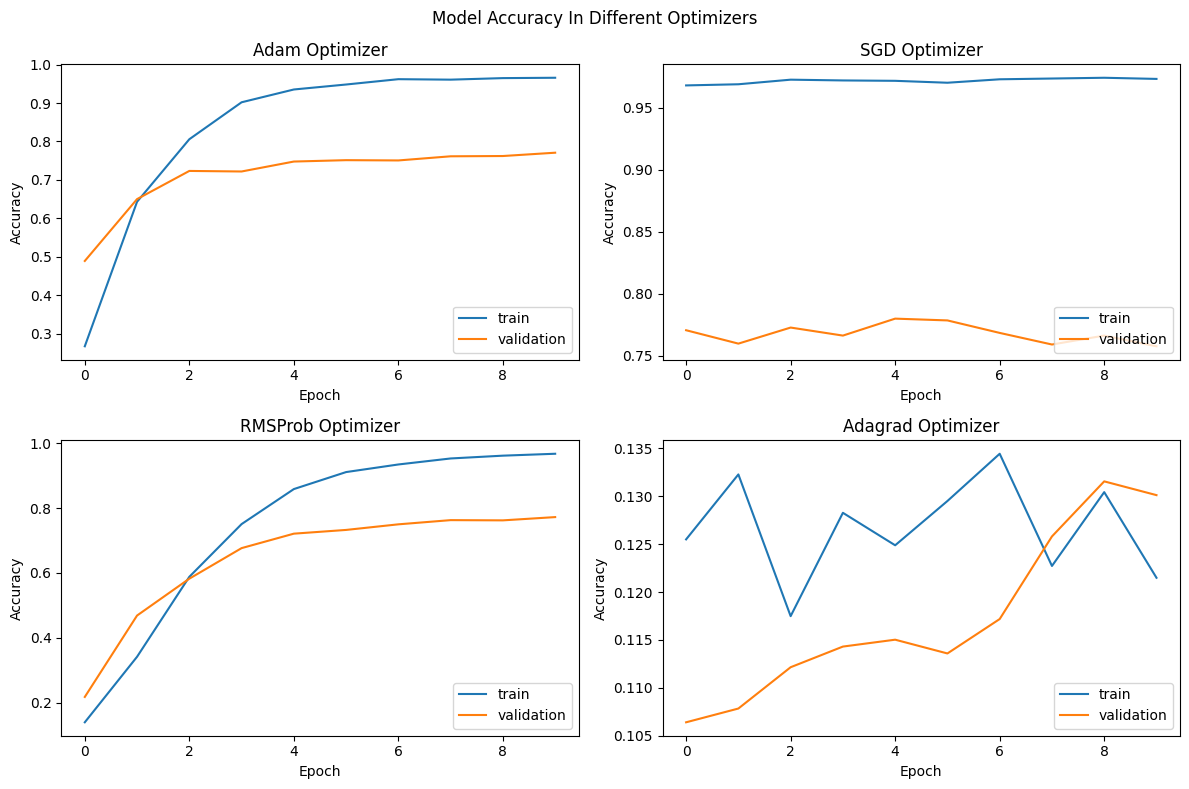

In [27]:
def accuracy_plot():
  fig, axs = plt.subplots(2,2, figsize=(12, 8))
  fig.suptitle("Model Accuracy In Different Optimizers")

  axs[0,0].plot(adam_history.history['accuracy'])
  axs[0,0].plot(adam_history.history['val_accuracy'])
  axs[0,0].legend(['train', 'validation'], loc='lower right')
  axs[0,0].set_xlabel("Epoch")
  axs[0,0].set_ylabel("Accuracy")
  axs[0,0].set_title("Adam Optimizer")

  axs[0,1].plot(sgd_history.history['accuracy'])
  axs[0,1].plot(sgd_history.history['val_accuracy'])
  axs[0,1].legend(['train', 'validation'], loc='lower right')
  axs[0,1].set_xlabel("Epoch")
  axs[0,1].set_ylabel("Accuracy")
  axs[0,1].set_title("SGD Optimizer")

  axs[1,0].plot(rmsprob_history.history['accuracy'])
  axs[1,0].plot(rmsprob_history.history['val_accuracy'])
  axs[1,0].legend(['train', 'validation'], loc='lower right')
  axs[1,0].set_xlabel("Epoch")
  axs[1,0].set_ylabel("Accuracy")
  axs[1,0].set_title("RMSProb Optimizer")

  axs[1,1].plot(adagrad_history.history['accuracy'])
  axs[1,1].plot(adagrad_history.history['val_accuracy'])
  axs[1,1].legend(['train', 'validation'], loc='lower right')
  axs[1,1].set_xlabel("Epoch")
  axs[1,1].set_ylabel("Accuracy")
  axs[1,1].set_title("Adagrad Optimizer")

  fig.tight_layout()
  fig.show()


accuracy_plot()


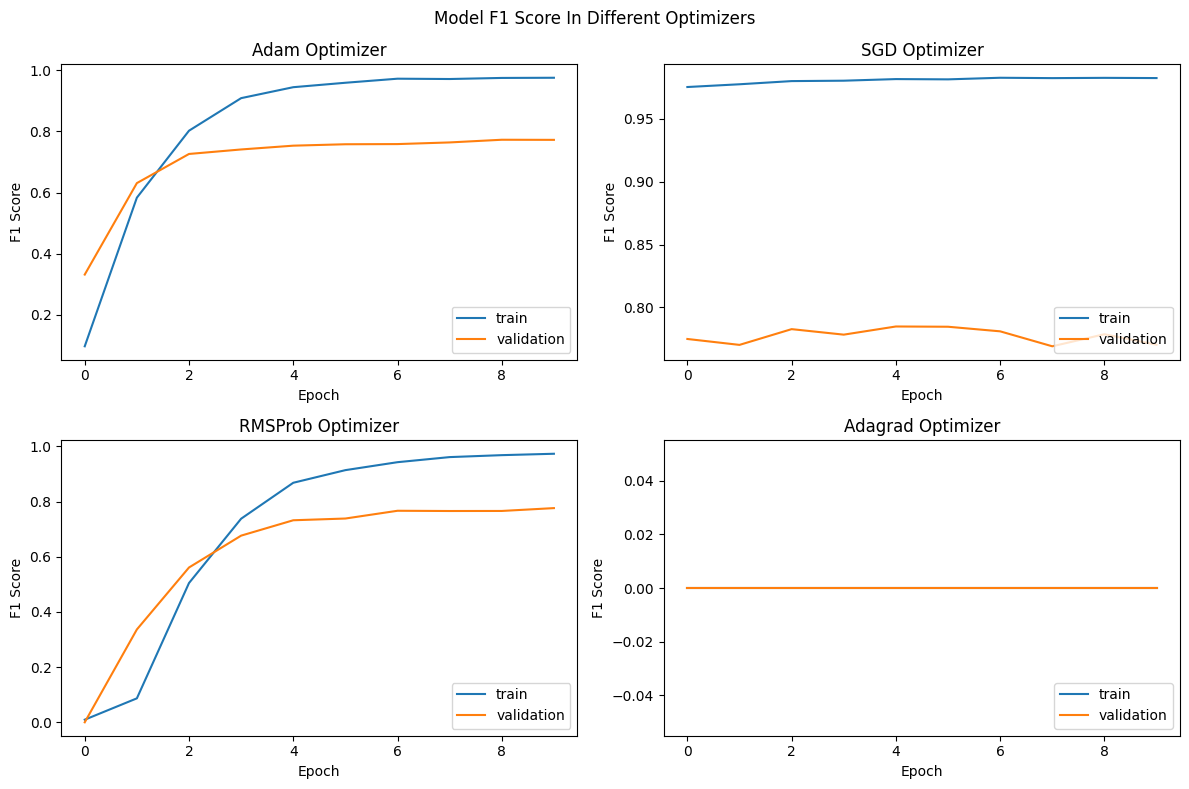

In [28]:
def f1score_plot():
  fig, axs = plt.subplots(2,2, figsize=(12, 8))
  fig.suptitle("Model F1 Score In Different Optimizers")

  axs[0,0].plot(adam_history.history['get_f1'])
  axs[0,0].plot(adam_history.history['val_get_f1'])
  axs[0,0].legend(['train', 'validation'], loc='lower right')
  axs[0,0].set_xlabel("Epoch")
  axs[0,0].set_ylabel("F1 Score")
  axs[0,0].set_title("Adam Optimizer")

  axs[0,1].plot(sgd_history.history['get_f1'])
  axs[0,1].plot(sgd_history.history['val_get_f1'])
  axs[0,1].legend(['train', 'validation'], loc='lower right')
  axs[0,1].set_xlabel("Epoch")
  axs[0,1].set_ylabel("F1 Score")
  axs[0,1].set_title("SGD Optimizer")

  axs[1,0].plot(rmsprob_history.history['get_f1'])
  axs[1,0].plot(rmsprob_history.history['val_get_f1'])
  axs[1,0].legend(['train', 'validation'], loc='lower right')
  axs[1,0].set_xlabel("Epoch")
  axs[1,0].set_ylabel("F1 Score")
  axs[1,0].set_title("RMSProb Optimizer")

  axs[1,1].plot(adagrad_history.history['get_f1'])
  axs[1,1].plot(adagrad_history.history['val_get_f1'])
  axs[1,1].legend(['train', 'validation'], loc='lower right')
  axs[1,1].set_xlabel("Epoch")
  axs[1,1].set_ylabel("F1 Score")
  axs[1,1].set_title("Adagrad Optimizer")

  fig.tight_layout()
  fig.show()


f1score_plot()


In [31]:
# Testing SGD Model
sgd_test_history = sgd_model.evaluate(X_test, y_test, batch_size=batch_size, return_dict=True)

# y_predict = adam_model.predict(X_test)

97/97 [==============================] - 2s 24ms/step - loss: 2.0794 - get_f1: 0.0000e+00 - accuracy: 0.1037


In [39]:
#y_predict

In [34]:
# SGD Model
batch_size = 32
sgd_model = get_model()
sgd_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[get_f1, 'accuracy'])
sgd_history = sgd_model.fit(X_train, y_train, batch_size=batch_size, epochs=10,  verbose=1)

Epoch 1/10
145/145 [==============================] - 15s 95ms/step - loss: 1.7781 - get_f1: 0.1535 - accuracy: 0.2915
Epoch 2/10
145/145 [==============================] - 13s 89ms/step - loss: 0.8257 - get_f1: 0.6682 - accuracy: 0.7091
Epoch 3/10
145/145 [==============================] - 13s 90ms/step - loss: 0.2741 - get_f1: 0.9160 - accuracy: 0.9100
Epoch 4/10
145/145 [==============================] - 13s 89ms/step - loss: 0.1318 - get_f1: 0.9675 - accuracy: 0.9590
Epoch 5/10
145/145 [==============================] - 13s 89ms/step - loss: 0.0998 - get_f1: 0.9761 - accuracy: 0.9678
Epoch 6/10
145/145 [==============================] - 13s 90ms/step - loss: 0.0835 - get_f1: 0.9804 - accuracy: 0.9709
Epoch 7/10
145/145 [==============================] - 13s 90ms/step - loss: 0.0805 - get_f1: 0.9810 - accuracy: 0.9719
Epoch 8/10
145/145 [==============================] - 13s 89ms/step - loss: 0.0737 - get_f1: 0.9826 - accuracy: 0.9745
Epoch 9/10
145/145 [============================